In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial


import jax_cosmo as jc
from jax import numpy as jnp

import jax

from diffrax import (
    diffeqsolve,
    TqdmProgressMeter,
    ConstantStepSize,
    Tsit5,
    ODETerm,
    PIDController,
    BacksolveAdjoint,
)

from jaxpm.pm import lpt
from jaxpm import LeapFrogODETerm, EfficientLeapFrog, symplectic_ode , diffrax_ode


from jax_cosmo import Cosmology
from pmesh.pm import ParticleMesh

import numpy as np
from fastpm.core import Cosmology as FastPMCosmology, Solver, leapfrog
from jaxpm.distributed import uniform_particles

from jaxpm.painting import cic_paint_dx
import matplotlib.pyplot as plt

# FastPM Init

In [2]:
Planck18 = partial(
    Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,
)

cosmo = Planck18()
cosmo._workspace
ref_cosmo = FastPMCosmology(cosmo)

In [ ]:
mesh_shape = [64, 64, 64]
box_size = [512.0, 512.0, 512.0]

# Generate initial particle positions
pm = ParticleMesh(BoxSize=box_size, Nmesh=mesh_shape, dtype="f4")
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
# Interpolate with linear_matter spectrum to get initial density field
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmo, k)

whitec = pm.generate_whitenoise(42, type="complex", unitary=False)


def pk_fn(x):
    return jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)


lineark = whitec.apply(
    lambda k, v: pk_fn(sum(ki**2 for ki in k) ** 0.5) ** 0.5
    * v
    * (1 / v.BoxSize).prod() ** 0.5
)
init_mesh = lineark.c2r().value  # XXX


ref_cosmo = FastPMCosmology(cosmo)
solver = Solver(pm, ref_cosmo, B=1)

statelpt = solver.lpt(lineark, grid, 0.1, order=1)
stages = np.linspace(0.1, 1.0, 10, endpoint=True)

# Init JaxPM

In [4]:
mesh_shape = [64, 64, 64]
box_size = [512.0, 512.0, 512.0]
snapshots = jnp.array([0.2, 0.5, 1.0])

omega_c = 0.25
sigma8 = 0.8
cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
ptcls = uniform_particles(mesh_shape)


@jax.jit
def run_lpt(cosmo, init_mesh):
    # Initial displacement
    cosmo._workspace = {}
    dx, p, f = lpt(cosmo, init_mesh, a=0.1, order=1)

    return dx, p, f


dx, p, f = run_lpt(cosmo, init_mesh)

print("Done with LPT")


@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def run_nbody(
    cosmo,
    y0,
    term,
    step_size=0.01,
    stepsize_controller=ConstantStepSize(),
    solver=Tsit5(),
):
    print("Jitted run_nbody")
    # Evolve the simulation forward
    ode_solutions = diffeqsolve(
        term,
        solver=solver,
        t0=0.1,
        t1=1.0,
        dt0=step_size,
        y0=y0,
        args=cosmo,
        stepsize_controller=stepsize_controller,
        progress_meter=TqdmProgressMeter(refresh_steps=2),
        # adjoint=BacksolveAdjoint(solver=solver),
    )

    return ode_solutions, ode_solutions.ys[-1]


@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def reverse_nbody(cosmo, y0, term, stepsize_controller, step_size=0.01, solver=Tsit5()):
    # Evolve the simulation forward
    print("Jitted reverse_nbody")
    ode_solutions = diffeqsolve(
        term,
        solver,
        t0=1.0,
        t1=0.1,
        dt0=-step_size,
        y0=y0,
        args=cosmo,
        stepsize_controller=stepsize_controller,
        progress_meter=TqdmProgressMeter(refresh_steps=2),
        # adjoint=BacksolveAdjoint(solver=solver),
    )

    return ode_solutions, ode_solutions.ys[-1]

Done with LPT


# Testing evaluation

In [5]:
stages = jnp.linspace(0.1, 1.0, 10, endpoint=True)
finalstate = None
leapfrog_stages = leapfrog(stages)
%time finalstate = solver.nbody(statelpt, leapfrog_stages)
fpm_mesh = pm.paint(finalstate.X).value

CPU times: user 18.6 s, sys: 1.2 s, total: 19.8 s
Wall time: 19.8 s


In [7]:
t1 = 1.0

solver = EfficientLeapFrog(initial_t0=0.1, final_t1=t1, cosmo=cosmo)
stepsize_controller = ConstantStepSize()
terms = jax.tree.map(
    LeapFrogODETerm,
    symplectic_ode(mesh_shape, paint_absolute_pos=False),
)
y0 = (dx, p)
cosmo._workspace = {}
args = cosmo


leapfrog_ode_solutions = diffeqsolve(
    terms,
    solver=solver,
    t0=0.1,
    t1=t1,
    dt0=0.1,
    y0=y0,
    args=args,
    stepsize_controller=stepsize_controller,
    progress_meter=TqdmProgressMeter(refresh_steps=2),
    # adjoint=BacksolveAdjoint(solver=solver),
)

yi type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
yi type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>


100.00%|██████████| [00:00<00:00, 726.44%/s]


In [8]:
t1 = 1.0

solver = Tsit5()
stepsize_controller = PIDController(rtol=1e-4,atol=1e-6)
term =ODETerm(diffrax_ode(mesh_shape, paint_absolute_pos=False))

y0 = jnp.stack([dx, p] , axis=0)
cosmo._workspace = {}
args = cosmo

tsit_ode_solutions = diffeqsolve(
    term,
    solver=solver,
    t0=0.1,
    t1=t1,
    dt0=0.1,
    y0=y0,
    args=args,
    stepsize_controller=stepsize_controller,
    progress_meter=TqdmProgressMeter(refresh_steps=2),
    # adjoint=BacksolveAdjoint(solver=solver),
)

yi type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>


100.00%|██████████| [00:01<00:00, 50.21%/s]


(Array(1.7998937e-05, dtype=float32), Array(0.00021121, dtype=float32))

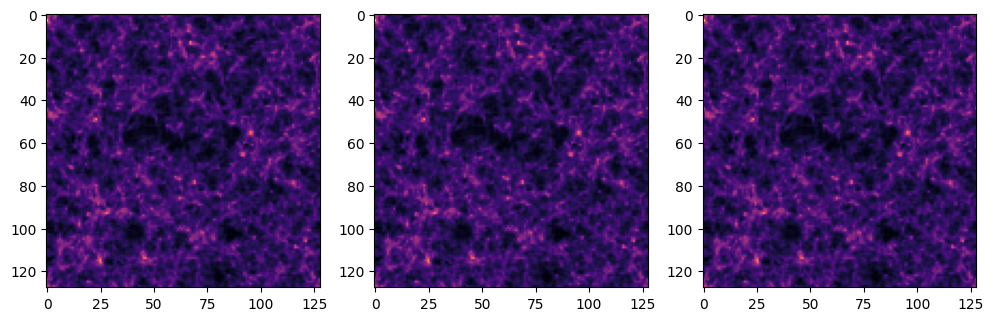

In [10]:
lf_pos = leapfrog_ode_solutions.ys[0][-1]
ts_pos = tsit_ode_solutions.ys[-1 , 0]
field_jpm_lf = cic_paint_dx(lf_pos)
field_jpm_ts = cic_paint_dx(ts_pos)
field_fpm = pm.paint(finalstate.X).value

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(field_jpm_lf.sum(axis=0) , cmap='magma')
plt.subplot(132)
plt.imshow(field_jpm_ts.sum(axis=0) , cmap='magma')
plt.subplot(133)
plt.imshow(field_fpm.sum(axis=0) , cmap='magma')


def MSE(x, y):
    return jnp.mean((x - y) ** 2)


MSE(field_jpm_lf, field_fpm) , MSE(field_jpm_ts, field_fpm)